# AsianFacesClassification

In [1]:
%%capture
! pip install transformers pytorch-lightning --quiet
! sudo apt -qq install git-lfs
! git config --global credential.helper store

In [42]:
try:
    import hugsvision
except:
    !pip install -q hugsvision
    import hugsvision

     |████████████████████████████████| 509 kB 5.6 MB/s 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


In [67]:
import math
import matplotlib.pyplot as plt
from hugsvision.nnet.VisionClassifierTrainer import VisionClassifierTrainer
from transformers import ViTFeatureExtractor, ViTForImageClassification
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import torch
import pytorch_lightning as pl
import glob
import os
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTModel

In [3]:
!rm -rf /content/preview

In [ ]:
!unzip /content/faces.zip

In [5]:
!mkdir /content/preview/

## Image Augmentation

In [6]:
folders = glob.glob("/content/faces/*")

In [7]:
for folder in tqdm(folders):
  images = Path(folder).glob("*.jpg")
  folder_name = folder.split('/')[3]
  preview_name = f'/content/preview/{folder_name}'
  # print(f'creating {folder_name}')
  if not os.path.exists(preview_name):
    os.makedirs(preview_name)
  datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
  for the_img in images:
    img = load_img(the_img) 
    x = img_to_array(img) 
    x = x.reshape((1,) + x.shape)  

    a = str(the_img).split("/")[-1]
    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir=preview_name, save_prefix=a, save_format='jpeg'):
        i += 1
        if i > 20:
          break
print('\n\npreview folder should be created with more images')

  0%|          | 0/4 [00:00<?, ?it/s]

preview folder should be created with more images


In [8]:
data_dir = Path('/content/preview')

## Splitting the dataset into Training and Testing


In [9]:
ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

## Create the data loader

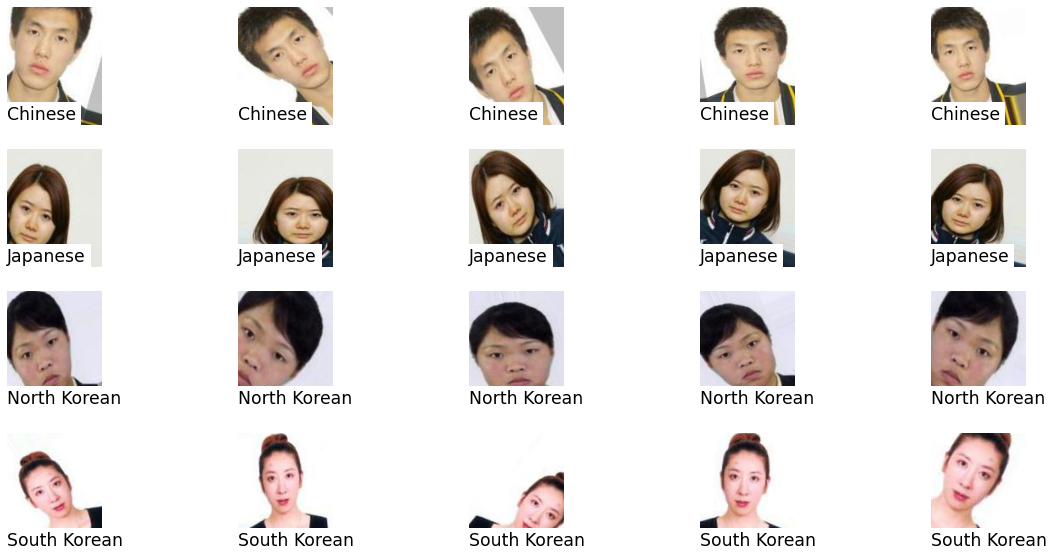

In [10]:
plt.figure(figsize=(20,10))
num_examples_per_class = 5
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

## Preparing Labels for Our Model's Config

In [11]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

## Image Classification Collator

In [12]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
 
    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings 

## Init Feature Extractor, Model, Data Loaders


google/vit-base-patch16-224-in21k is the best model I found so far. However, following list of **Vision Transformer models** can also be tried.
- google/vit-base-patch16–224
- facebook/deit-base-distilled-patch16–224
- microsoft/beit-base-patch16–224
- google/vit-base-patch16–224-in21k

In [36]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training

In [37]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy()

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [38]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(gpus=1, precision=16, max_epochs=2)# Epochcs can be increased but be aware of overfitting
trainer.fit(classifier, train_loader, val_loader)

INFO:pytorch_lightning.utilities.seed:Global seed set to 42
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                     

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [39]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])

Preds:  tensor([3, 0, 1, 3, 1, 1, 0, 1])
Labels: tensor([3, 0, 1, 3, 1, 1, 0, 1])


# Another method of training and testing the model

In [58]:
from hugsvision.dataio.VisionDataset import VisionDataset

train, test, id2label, label2id = VisionDataset.fromImageFolder(
	"/content/preview/",
	test_ratio   = 0.15,
	balanced     = True,
	augmentation = True,
)

Split Datasets...
Balance train dataset...
The less represented label in train as 483 occurrences
Size of train after balancing is 1932
train_ds:  1642
+---------+---------+----------+--------------+--------------+-------+
| Dataset | Chinese | Japanese | North Korean | South Korean | Total |
+---------+---------+----------+--------------+--------------+-------+
|  Train  |   421   |   409    |     408      |     404      | 1642  |
|  Test   |   62    |    74    |      75      |      79      |  290  |
+---------+---------+----------+--------------+--------------+-------+


In [ ]:
trainer = VisionClassifierTrainer(
	model_name   = "AsianFaces",
	train      	 = train,
	test      	 = test,
	output_dir   = "./AsianFacesOut/",
	max_epochs   = 4,
	batch_size   = 32, # On RTX 2080 Ti
    lr 		     = 2e-5,
	fp16	     = True,
	model = ViTForImageClassification.from_pretrained(
	    'google/vit-base-patch16-224-in21k',
	    num_labels = len(label2id),
	    label2id   = label2id,
	    id2label   = id2label
	),
	feature_extractor = ViTFeatureExtractor.from_pretrained(
		'google/vit-base-patch16-224-in21k',
	),
)

In [60]:
hyp, ref = trainer.evaluate_f1_score()

100%|██████████| 290/290 [00:04<00:00, 59.21it/s]

              precision    recall  f1-score   support

     Chinese     1.0000    1.0000    1.0000        62
    Japanese     1.0000    1.0000    1.0000        74
North Korean     1.0000    1.0000    1.0000        75
South Korean     1.0000    1.0000    1.0000        79

    accuracy                         1.0000       290
   macro avg     1.0000    1.0000    1.0000       290
weighted avg     1.0000    1.0000    1.0000       290

Logs saved at: ./AsianFacesOut/ASIANFACES/4_2022-09-26-19-22-08


# Predicting using the tarined model

## Predict with first trained model

In [52]:
def prediction(img_path):
   im=Image.open(img_path)
   encoding = feature_extractor(images=im, return_tensors="pt")
   encoding.keys()
   pixel_values = encoding['pixel_values']
   outputs = model(pixel_values)
   result = outputs.logits.softmax(1).argmax(1)
   new_result = result.tolist() 
   for i in new_result:
     return(id2label[str(i)])

def process_image(image_path):
   pil_image = Image.open(image_path)
   if pil_image.size[0] > pil_image.size[1]:
       pil_image.thumbnail((5000, 256))
   else:
       pil_image.thumbnail((256, 5000))
   left_margin = (pil_image.width-224)/2
   bottom_margin = (pil_image.height-224)/2
   right_margin = left_margin + 224
   top_margin = bottom_margin + 224
   pil_image = pil_image.crop((left_margin, bottom_margin, 
                               right_margin, top_margin))
   np_image = np.array(pil_image)/255
   mean = np.array([0.485, 0.456, 0.406])
   std = np.array([0.229, 0.224, 0.225])
   np_image = (np_image - mean) / std
   np_image = np_image.transpose((2, 0, 1))
   return np_image

In [64]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [61]:
def display_image(image_dir):

    # Plot flower input image
    plt.figure(figsize = (6,10))
    plot_1 = plt.subplot(2,1,1)
    
    image = process_image(image_dir)
    

    asl_sign = image_dir[image_dir.rfind('/')+1:]
    
    pred= prediction(image_dir)

    plot_1.set_xlabel("The predicted sign: "+pred)

    imshow(image, plot_1, title=asl_sign);

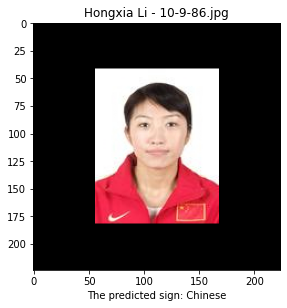

In [66]:
display_image('/content/faces/Chinese/Hongxia Li - 10-9-86.jpg')

## Predict with Second Trained Model

In [71]:
import os.path
from transformers import ViTFeatureExtractor, ViTForImageClassification
from hugsvision.inference.VisionClassifierInference import VisionClassifierInference

path = "/content/AsianFacesOut/ASIANFACES/4_2022-09-26-19-22-08/model"
img  = "/content/faces/Chinese/Ailun Guo - 14-11-93.jpg"

classifier = VisionClassifierInference(
    feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k'),
    model = ViTForImageClassification.from_pretrained(path),
)

label = classifier.predict(img_path=img)
print('\n\n\n')
print('-------------------------------------------------------------')
print("Predicted face is :", label)

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/preprocessor_config.json
Feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

loading configuration file /content/AsianFacesOut/ASIANFACES/4_2022-09-26-19-22-08/model/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "Chinese",
    "1": "Japanese",
    "2": "North Korean",
    "3": "South Korean"
  },
  "image_size": 224,
  "initi

Model loaded!




-------------------------------------------------------------
Predicted face is : Chinese
